# Forum Meta Analysis

In this notebook, we will perform a meta-analysis of two flat earth forums.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from datetime import datetime
import numpy as np
import seaborn as sns
import sys

sys.path.insert(1, "../")

from language_change_methods.utility_functions import tokenise, get_time_windows, get_data_windows
from settings import TFES_FP, TFES_TOK_FP

sys.path.insert(1, "../utilities")
from helpers import load_posts, load_toks

pd.plotting.register_matplotlib_converters()

# On home desktop
DB_FP = TFES_FP

GRAPH_DIR = "./Graphs"

MAIN_COLOUR = "#7fc97f"
SECOND_COLOUR = "#beaed4"

In [2]:
sql_get_all_posts ="""
SELECT p.uid, p.poster_name, p.body, p.time, t.name, t.uid, b.name, u.uid, u.position, u.personal_text, u.custom_title, u.location, u.age, u.gender
FROM posts as p
LEFT JOIN users as u
ON u.uid = p.user
INNER JOIN topics as t
ON t.uid = p.topic
INNER JOIN boards as b
ON b.uid= t.board;""".strip()

In [3]:
%%time
import sqlite3

conn = sqlite3.connect(DB_FP)
curs = conn.cursor()

# Gets all the contributions and creates a nice dataframe
all_posts = pd.read_sql_query(sql_get_all_posts, conn)
all_posts.columns = ['uid', 'poster_name', 'body', 'time', 'topic', 'topic_id', 'board', 'poster_id', 'position', 'personal_text', 'custom_title', 'location', 'age', 'gender']
all_posts.set_index("uid", inplace=True)
convert_to_date = lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S")
all_posts['time'] = all_posts['time'].apply(convert_to_date)
all_posts.sort_values("time", inplace=True)

Wall time: 2.02 s


In [4]:
all_posts.shape[0]

126200

In [5]:
print("Num Posts:\t", len(all_posts))
print("Num Users:\t", len(all_posts["poster_id"].unique()))
print("Num Boards:\t", len(all_posts["board"].unique()))
print("Num Topics:\t", len(all_posts["topic"].unique()))

Num Posts:	 126200
Num Users:	 2319
Num Boards:	 13
Num Topics:	 5138


In [6]:
all_posts.head(5)

,poster_name,body,time,topic,topic_id,board,poster_id,position,personal_text,custom_title,location,age,gender
uid,,,,,,,,,,,,,
1,None,"I'm not sure what took the .org site down, but...",2013-08-30 16:09:44,The .org site is down,1,Announcements,1.0,Administrator,Professional computer somebody,None,None,NaN,None
2,None,F*cking .org has been shit lately. What the f...,2013-08-30 16:32:03,The .org site is down,1,Announcements,5.0,None,Kentucky Gentleman,None,On yo mama,NaN,Male
3,None,<quote msg=957 idx=86685> The only people who ...,2013-08-30 16:34:32,The .org site is down,1,Announcements,1.0,Administrator,Professional computer somebody,None,None,NaN,None
4,None,I have just fixed a problem with using non-ASC...,2013-08-30 17:41:50,The .org site is down,1,Announcements,1.0,Administrator,Professional computer somebody,None,None,NaN,None
5,None,Obviously Blanko had something to do with it.,2013-08-30 20:01:54,The .org site is down,1,Announcements,6.0,None,None,None,Winland,35.0,Male


## Posts per board

In [7]:
posts_per_board = all_posts.groupby("board").size().sort_values(ascending=True)

In [8]:
# flat_earth_boards = [5, 7, 8, 19, 23]
# off_topic_boards = [9, 10, 11, 12]
from helpers import flat_earth_boards, off_topic_boards

boards = pd.read_sql_query("SELECT * FROM boards;", conn).set_index("uid")["name"]

flat_earth_boards = [boards[x] for x in flat_earth_boards]
off_topic_boards = [boards[x] for x in off_topic_boards]

colour_list = ["#66c2a5", "#fc8d62", "#8da0cb"]
hatch_list = ["////", "oo", "...."]

def get_board_colour(board):
    if board in flat_earth_boards:
        return colour_list[0]
    elif board in off_topic_boards:
        return colour_list[1]
    else:
        return colour_list[2]
    
def get_board_hatch(board):
    if board in flat_earth_boards:
        return hatch_list[0]
    elif board in off_topic_boards:
        return hatch_list[1]
    else:
        return hatch_list[2]

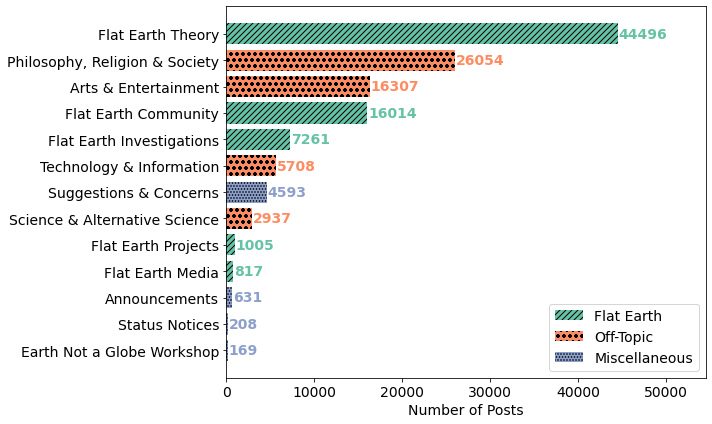

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(posts_per_board.index, posts_per_board.values, 
        color=[get_board_colour(b) for b in posts_per_board.index])
ax.set_xlabel("Number of Posts", fontsize=14)

for i, v in enumerate(posts_per_board):
    ax.text(v+100, i, str(v), va='center', 
            color=get_board_colour(posts_per_board.index[i]), 
            fontweight='bold', fontsize=14)
    
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colour_list[0], lw=4),
                Line2D([0], [0], color=colour_list[1], lw=4),
                Line2D([0], [0], color=colour_list[2], lw=4)]

import matplotlib.patches as mpatches
leg_lines = [mpatches.Patch( facecolor=colour_list[0], hatch=r'////',label='Flat Earth'), 
             mpatches.Patch( facecolor=colour_list[1], hatch='oo',label='Off-Topic'), 
             mpatches.Patch(facecolor=colour_list[2], hatch='....',label='Miscellaneous')]

# Loop over the bars
for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(get_board_hatch(posts_per_board.index[i]))
    
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.set_xlim([0, posts_per_board.max()+10000])
# ax.legend(custom_lines, ["Flat Earth", "Off-Topic", "Miscellaneous"], loc="lower right", fontsize="large")
ax.legend(handles=leg_lines, loc="lower right", fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(GRAPH_DIR, "board_posts.pdf"))
plt.show()

In [10]:
posts_per_board.describe()

count       13.000000
mean      9707.692308
std      13143.861402
min        169.000000
25%        817.000000
50%       4593.000000
75%      16014.000000
max      44496.000000
dtype: float64

## Users Per Board

In [11]:
users_per_board = all_posts.groupby("board").apply(lambda x: len([u for u in x["poster_id"].unique() if not np.isnan(u)]))

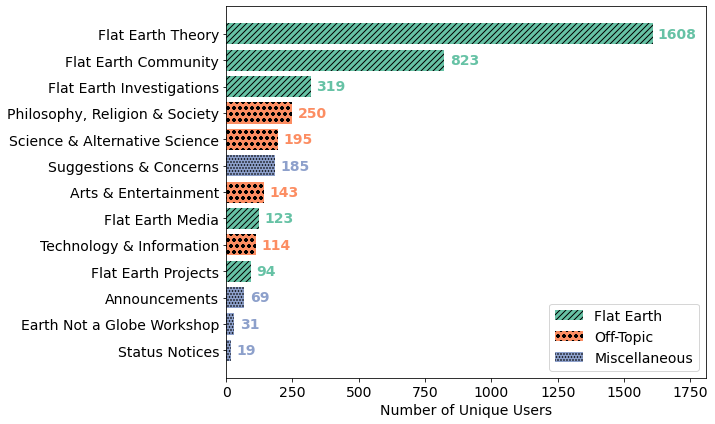

In [12]:
users_per_board.sort_values(ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(users_per_board.index, users_per_board.values, 
        color=[get_board_colour(b) for b in users_per_board.index])
ax.set_xlabel("Number of Unique Users", fontsize=14)

for i, v in enumerate(users_per_board):
    ax.text(v+20, i, str(v), va='center', 
            color=get_board_colour(users_per_board.index[i]), 
            fontweight='bold', fontsize=14)

import matplotlib.patches as mpatches
leg_lines = [mpatches.Patch( facecolor=colour_list[0], hatch=r'////',label='Flat Earth'), 
             mpatches.Patch( facecolor=colour_list[1], hatch='oo',label='Off-Topic'), 
             mpatches.Patch(facecolor=colour_list[2], hatch='....',label='Miscellaneous')]

# Loop over the bars
for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(get_board_hatch(users_per_board.index[i]))
    
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.set_xlim([0, users_per_board.max()+200])
ax.legend(handles=leg_lines, loc="lower right", fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(GRAPH_DIR, "board_unique_users.pdf"))
plt.show()

## Boards Per User

In [13]:
# Gets the number of posts each user has in each board.
user_n_posts_per_board = all_posts.groupby("poster_id").apply(lambda x: x.groupby("board").size()).unstack(level=1).fillna(0)
boards_per_user = user_n_posts_per_board.apply(lambda x: len(x[x>0]), axis=1)

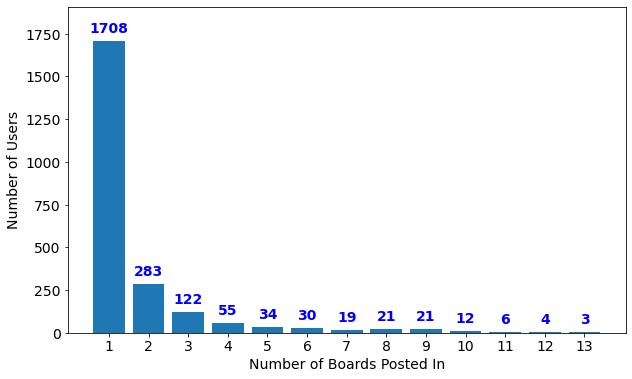

In [14]:
u_num_boards_counts = boards_per_user.groupby(boards_per_user.values).size()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(u_num_boards_counts.index, u_num_boards_counts.values)
ax.set_xlabel("Number of Boards Posted In", fontsize=14)
ax.set_ylabel("Number of Users", fontsize=14)
# plt.xticks(rotation=90)

for i, v in enumerate(u_num_boards_counts):
    ax.text(i+1, v+50, str(v), ha='center', color='blue', fontweight='bold', fontsize=14)
    
ax.set_xticks(u_num_boards_counts.index)
ax.set_ylim([0, users_per_board.max()+300])

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

fig.savefig(os.path.join(GRAPH_DIR, "num_boards_per_user.pdf"))
plt.show()

## Posts Per User

Below, we check how many unique users there are, and how many do not appear in the user DB that should.

In [15]:
all_user_ids = pd.read_sql_query("SELECT user FROM posts;", conn)["user"].unique().astype(int)
print("Number of users: {}".format(all_user_ids.shape[0]))
print("users not in db: {}".format(all_user_ids[~np.isin(all_user_ids, all_posts["poster_id"].unique().astype(int))]))

Number of users: 2319
users not in db: []


Now, we'll look at the number of posts per user.

In [16]:
posts_per_user = all_posts.groupby("poster_id").size()
n = 100
print(f"Num Users w/ >{n} Posts: ", len(posts_per_user[posts_per_user > n]))
print("Mean posts per user: ", posts_per_user.mean())
print("Median posts per user: ", posts_per_user.median())

Num Users w/ >100 Posts:  142
Mean posts per user:  46.86971527178602
Median posts per user:  2.0


In [17]:
posts_per_user.describe()

count    2318.000000
mean       46.869715
std       300.957266
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      6963.000000
dtype: float64

In [18]:
print("{} posts by top 20 users.".format(posts_per_user.sort_values(ascending=False).head(20).sum()))

52054 posts by top 20 users.


Plot the distribution of posts per user.

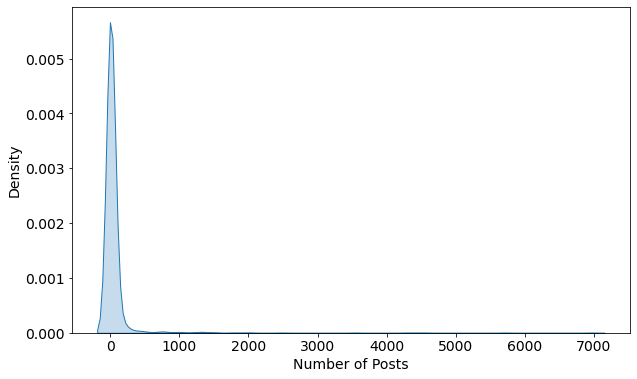

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(posts_per_user, ax=ax, fill=True)
ax.set_xlabel("Number of Posts", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
fig.savefig(os.path.join(GRAPH_DIR, "posts_per_user_all.pdf"))
plt.show()

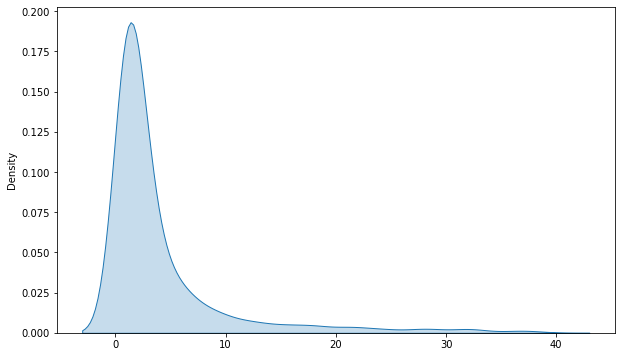

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(posts_per_user[posts_per_user < posts_per_user.quantile(0.9)], ax=ax, fill=True)
plt.show()

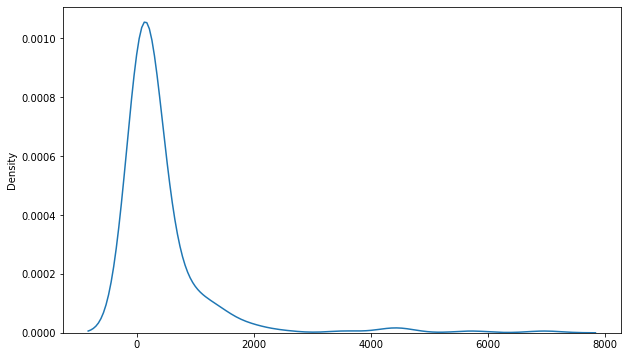

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(posts_per_user[posts_per_user > posts_per_user.quantile(0.9)], ax=ax)
plt.show()

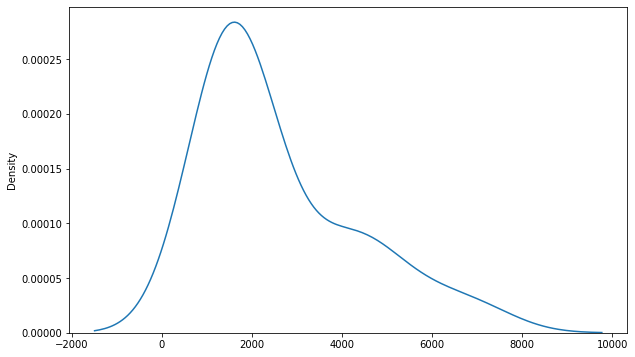

In [22]:
# posts per user of top 20 users
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(posts_per_user.sort_values(ascending=False).head(20), ax=ax)
plt.show()

Plot of cumulative posts over time

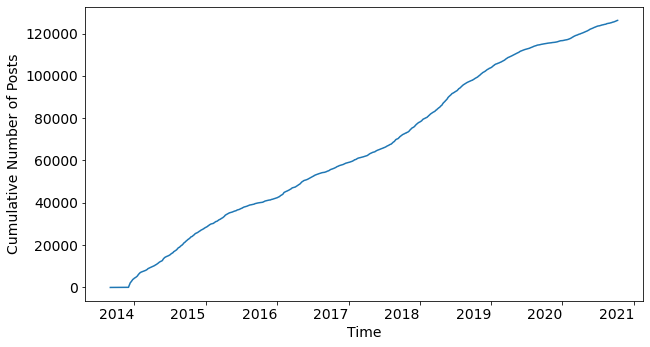

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
cum_posts = all_posts.groupby("time").size().cumsum()
cum_posts.iloc[1:].plot(ax=ax)
ax.set_ylabel("Cumulative Number of Posts", fontsize=14)
ax.set_xlabel("Time", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)

fig.savefig(os.path.join(GRAPH_DIR, "cum_posts_over_time.pdf"))
plt.show()

In [24]:
def find_first_and_last(curr_posts):
    curr_posts = curr_posts.sort_values("time", ascending=True)
    return (curr_posts["time"].iloc[0], curr_posts["time"].iloc[-1])

first_and_last = all_posts.groupby("poster_id").apply(find_first_and_last)

In [25]:
user_lifetimes = first_and_last.apply(lambda x: (x[1] - x[0]).days + 1)

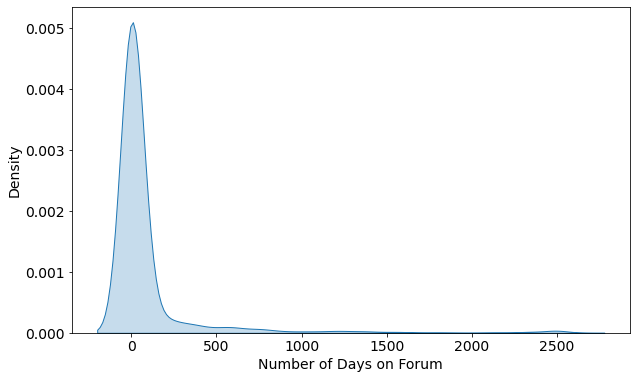

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(user_lifetimes, ax=ax, fill=True)
ax.set_xlabel("Number of Days on Forum", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
fig.savefig(os.path.join(GRAPH_DIR, "user_lifetime_dist.pdf"))
plt.show()

## Some stats for the paper

In [27]:
print(f"{len(posts_per_user)} posters")

2318 posters


In [28]:
print("{} posts by top 20 users.".format(posts_per_user.sort_values(ascending=False).head(20).sum()))
print("{:.2f}% of posts.".format(posts_per_user.sort_values(ascending=False).head(20).sum() / posts_per_user.sum() * 100))

52054 posts by top 20 users.
47.91% of posts.


In [29]:
print("{} users posted once".format(len(posts_per_user[posts_per_user==1])))
print("{:.2f}% of users".format(len(posts_per_user[posts_per_user==1]) / len(posts_per_user) * 100))
print("{:.2f}% of posts".format(posts_per_user[posts_per_user==1].sum() / posts_per_user.sum() * 100))

964 users posted once
41.59% of users
0.89% of posts


In [30]:
print(f"Num Users w/ >{10} Posts: ", len(posts_per_user[posts_per_user > 10]))
print(f"Num Users w/ >{100} Posts: ", len(posts_per_user[posts_per_user > 100]))

Num Users w/ >10 Posts:  439
Num Users w/ >100 Posts:  142


In [31]:
# Looking only at off topic boards, see if any have >0 posts for each user
u_is_off_topic = user_n_posts_per_board.apply(lambda x: x[x.index.isin(off_topic_boards)], axis=1).any(axis=1)

off_topic_users = user_n_posts_per_board.index[u_is_off_topic]
not_off_topic_users = user_n_posts_per_board.index[~u_is_off_topic]

print(f"Group1: Users who post in off-topic boards:\t {len(off_topic_users)}")
print(f"Group2: Users who don't post in off-topic boards:\t {len(not_off_topic_users)}")

print()

print(f"Group 1 posts:\t{len(all_posts[all_posts['poster_id'].isin(off_topic_users)])}")
print(f"Group 2 posts:\t{len(all_posts[all_posts['poster_id'].isin(not_off_topic_users)])}")

Group1: Users who post in off-topic boards:	 391
Group2: Users who don't post in off-topic boards:	 1927

Group 1 posts:	94119
Group 2 posts:	14525


In [32]:
print("{} users active for single day".format(len(user_lifetimes[user_lifetimes == 1])))
print("{:.2f}% of users".format(len(user_lifetimes[user_lifetimes == 1]) / len(user_lifetimes) * 100))
one_day = all_posts[all_posts["poster_id"].isin(user_lifetimes[user_lifetimes == 1].index)]
print("{:.2f}% of posts".format(len(one_day) / len(all_posts) * 100))

1399 users active for single day
60.35% of users
1.84% of posts


In [33]:
print("{} users active for over 5 years".format(len(user_lifetimes[user_lifetimes > 1825])))
print("{:.2f}% of users".format(len(user_lifetimes[user_lifetimes > 1825]) / len(user_lifetimes) * 100))
over_5yrs = all_posts[all_posts["poster_id"].isin(user_lifetimes[user_lifetimes > 1825].index)]
print("{:.2f}% of posts".format(len(over_5yrs) / len(all_posts) * 100))

24 users active for over 5 years
1.04% of users
37.61% of posts


In [34]:
flat_earth_posts = all_posts[all_posts["board"].isin(flat_earth_boards)]
off_topic_posts = all_posts[all_posts["board"].isin(off_topic_boards)]
misc_posts = all_posts[~all_posts["board"].isin(flat_earth_boards + off_topic_boards)]

print(f"Posts in Flat Earth Discussion:\t\t{flat_earth_posts.shape[0] / all_posts.shape[0] * 100:.2f}")
print(f"Posts in Off-Topic Discussion:\t\t{off_topic_posts.shape[0] / all_posts.shape[0] * 100:.2f}")
print(f"Posts in Miscellaneous Discussion:\t{misc_posts.shape[0] / all_posts.shape[0] * 100:.2f}")

Posts in Flat Earth Discussion:		55.15
Posts in Off-Topic Discussion:		40.42
Posts in Miscellaneous Discussion:	4.44


In [35]:
users = pd.read_sql_query("SELECT * FROM users", conn).set_index("uid")
users_with_roles = users["position"][users["position"].notnull()]

print(f"{len(users_with_roles):.2f} users with roles")
print("{:.2f}% of posts".format(len(all_posts[all_posts['poster_id'].isin(users_with_roles.index)]) / len(all_posts) * 100))

12.00 users with roles
23.24% of posts


## Doing Some Text Meta-analysis

In [36]:
%%time
all_toks = {int(x[0]): x[1] for x in load_toks(TFES_TOK_FP)}
all_toks = pd.Series(all_toks)
all_toks = all_toks[all_toks.index.isin(all_posts.index)]

Wall time: 15.1 s


In [37]:
all_toks.apply(len).sum()

11863865

In [38]:
all_toks

1         [i, 'm, not, sure, what, took, the, .org, site...
2         [f*cking, .org, has, been, shit, lately, ., wh...
3         [the, only, people, who, could, tell, you, app...
4         [i, have, just, fixed, a, problem, with, using...
5         [obviously, blanko, had, something, to, do, wi...
                                ...                        
126196    [in, the, same, paper, quoted, by, fisherman, ...
126197    [what, about, ", some, people, might, not, see...
126198                                   [r, o, u, n, d, y]
126199    [he, also, says, in, the, same, paper, that, t...
126200    [this, is, just, a, statement, ,, it, 's, not,...
Length: 124506, dtype: object

In [39]:
post_lengths = all_toks.apply(len)
print("Median words / post:" , post_lengths.median())
print("Mean words / post:" , post_lengths.mean())
print("Num words: ", post_lengths.sum())

Median words / post: 49.0
Mean words / post: 95.28749618492282
Num words:  11863865


In [40]:
words_per_user = post_lengths.groupby(all_posts.poster_id).sum()
print("Median words / user:" , words_per_user.median())
print("Mean words / user:" , words_per_user.mean())

Median words / user: 209.0
Mean words / user: 4443.872995231903


In [41]:
words_per_user.sort_values(ascending=False).head(10)

poster_id
38.0      614071
2.0       470238
1206.0    366357
59.0      323763
706.0     266163
11.0      253498
1.0       243783
315.0     243075
21.0      239868
1448.0    205094
dtype: int64

#### Plot Num Words Per Board

In [42]:
words_per_board = post_lengths.groupby(all_posts["board"]).sum().sort_values(ascending=True)
words_per_board

board
Status Notices                      11425
Earth Not a Globe Workshop          22758
Announcements                       34303
Flat Earth Media                    92057
Flat Earth Projects                107262
Science & Alternative Science      233545
Technology & Information           280087
Suggestions & Concerns             345507
Flat Earth Investigations          908581
Arts & Entertainment              1189883
Flat Earth Community              1647033
Philosophy, Religion & Society    1913710
Flat Earth Theory                 5077714
dtype: int64

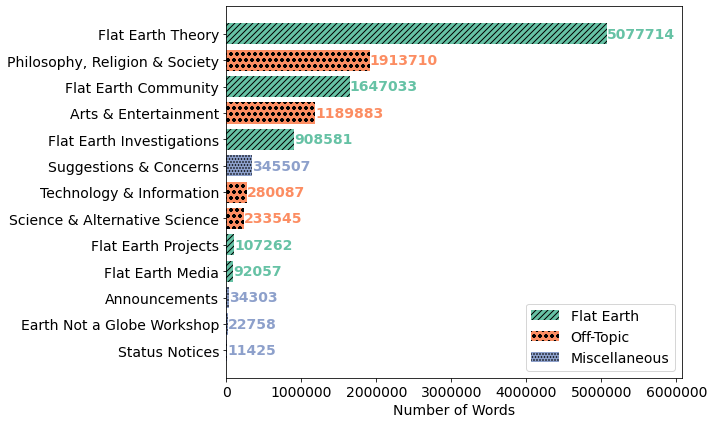

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(words_per_board.index, words_per_board.values, 
        color=[get_board_colour(b) for b in words_per_board.index])
ax.set_xlabel("Number of Words", fontsize=14)

for i, v in enumerate(words_per_board):
    ax.text(v+100, i, str(v), va='center', 
            color=get_board_colour(words_per_board.index[i]), 
            fontweight='bold', fontsize=14)
    
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colour_list[0], lw=4),
                Line2D([0], [0], color=colour_list[1], lw=4),
                Line2D([0], [0], color=colour_list[2], lw=4)]

import matplotlib.patches as mpatches
leg_lines = [mpatches.Patch( facecolor=colour_list[0], hatch=r'////',label='Flat Earth'), 
             mpatches.Patch( facecolor=colour_list[1], hatch='oo',label='Off-Topic'), 
             mpatches.Patch(facecolor=colour_list[2], hatch='....',label='Miscellaneous')]

# Loop over the bars
for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(get_board_hatch(words_per_board.index[i]))
    
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.set_xlim([0, words_per_board.max()+1000000])
# ax.legend(custom_lines, ["Flat Earth", "Off-Topic", "Miscellaneous"], loc="lower right", fontsize="large")
ax.legend(handles=leg_lines, loc="lower right", fontsize=14)
ax.ticklabel_format(axis='x', useOffset=False, style='plain')
plt.tight_layout()
fig.savefig(os.path.join(GRAPH_DIR, "board_words.pdf"))
plt.show()

## Let's Look at Windows

In [44]:
%%time
time_window_post_counts = [[window, len(posts)] for window, posts in get_time_windows(all_posts, 90, 30, time_column="time")]
time_window_post_counts = pd.Series([x[1] for x in time_window_post_counts], index=[x[0] for x in time_window_post_counts])

Wall time: 55.3 s


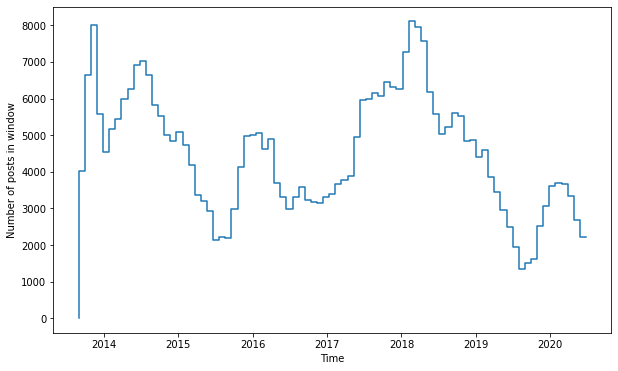

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_window_post_counts.index, time_window_post_counts.values, drawstyle='steps-pre')
ax.set_xlabel("Time")
ax.set_ylabel("Number of posts in window")
fig.savefig(os.path.join(GRAPH_DIR, "window_posts_over_time.pdf"))
plt.show()

In [46]:
all_posts.loc[:,"flag"] = [True] * len(all_posts)
rolling_post_counts = all_posts.rolling("90D", on="time").count()["flag"]

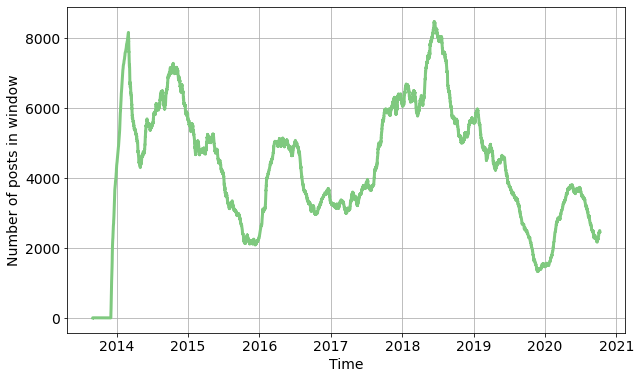

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(all_posts["time"], rolling_post_counts.values, color=MAIN_COLOUR, lw=3)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
fig.savefig(os.path.join(GRAPH_DIR, "posts_over_time.pdf"))
plt.show()

In [48]:
import matplotlib.dates as mdates

def plot_timeline(ax, dates, names, fontsize=16):
    # Choose some nice levels
#     levels = np.tile([-3, 3, -2, 2, -1, 1],
#                     int(np.ceil(len(dates)/6)))[:len(dates)]
    
    # Choose some nice levels
    levels = np.tile([-7, -4, 7, 4],
                    int(np.ceil(len(dates)/4)))[:len(dates)]

    ax.vlines(dates, 0, levels, color="tab:red", alpha=0.75)  # The vertical stems.
    ax.plot(dates, np.zeros_like(dates), "-o",
            color="k", markerfacecolor="w", markersize=14)  # Baseline and markers on it.

    # annotate lines
    for d, l, r in zip(dates, levels, names):
        ax.annotate(r, xy=(d, l),
                    xytext=(0, np.sign(l)), textcoords="offset points",
                    horizontalalignment="center",
                    verticalalignment="bottom" if l > 0 else "top", fontsize=fontsize)

    # format xaxis with 4 month intervals
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=fontsize)

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylim(-12, 12)

    ax.margins(y=0.1)
    ax.grid()

In [49]:
events = pd.read_csv("../data/fe-events.csv", delimiter=",")
events["date"] = events["date"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
events = events.set_index("date")

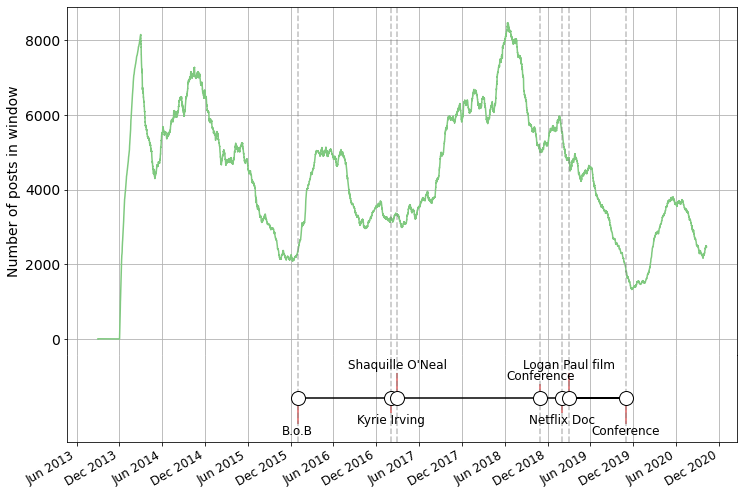

In [50]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

ax.plot(all_posts["time"], rolling_post_counts.values, color=MAIN_COLOUR)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()

for e in events.index:
    ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
    ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

# Comment this chunk out if you don't want the timeline
names = events.event
dates = events.index
plot_timeline(ax_time, dates, names, fontsize=12)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

# fig.savefig(os.path.join(GRAPH_DIR, "window_posts_over_time.pdf"))
plt.show()

### Google Trends

In [51]:
trends = pd.read_csv("../data/FE_Google_Trends.csv", delimiter=",")
trends["date"] = trends["Month"].apply(lambda x: datetime.strptime(x, "%Y-%m"))
trends = trends.set_index("date")["Value"]
trends = trends[trends.index < datetime(2021, 1, 1)]

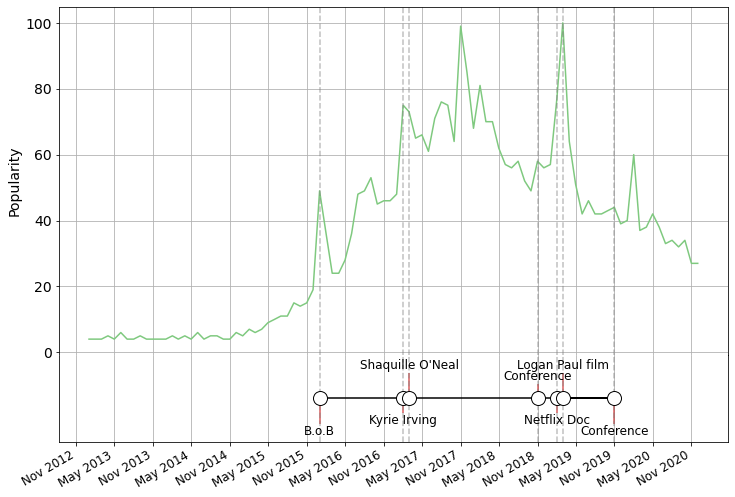

In [52]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

ax.plot(trends.index, trends.values, color=MAIN_COLOUR)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Popularity", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()

for e in events.index:
    ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
    ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

# Comment this chunk out if you don't want the timeline
names = events.event
dates = events.index
plot_timeline(ax_time, dates, names, fontsize=12)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

# fig.savefig(os.path.join(GRAPH_DIR, "window_posts_over_time.pdf"))
plt.show()

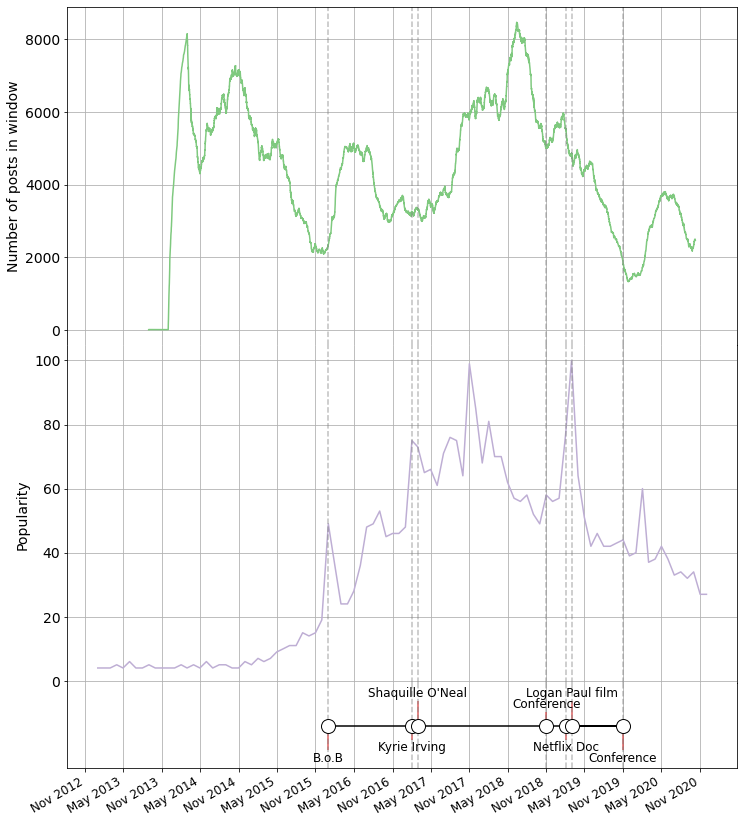

In [53]:
fig = plt.figure(figsize=(12, 14))
gs = gridspec.GridSpec(3, 1, height_ratios=[4, 4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax)
ax_time = plt.subplot(gs[2], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

ax.plot(all_posts["time"], rolling_post_counts.values, color=MAIN_COLOUR)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()

ax2.plot(trends.index, trends.values, color=SECOND_COLOUR)
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("Popularity", fontsize=14)
plt.setp(ax2.get_xticklabels(), fontsize=0)
plt.setp(ax2.get_yticklabels(), fontsize=14)
ax2.grid()

for e in events.index:
    ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
    ax2.axvline(e, linestyle="--", alpha=0.5, color="gray")
    ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

# Comment this chunk out if you don't want the timeline
names = events.event
dates = events.index
plot_timeline(ax_time, dates, names, fontsize=12)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

ax2.spines['top'].set_visible(False)

# fig.savefig(os.path.join(GRAPH_DIR, "window_posts_over_time.pdf"))
plt.show()

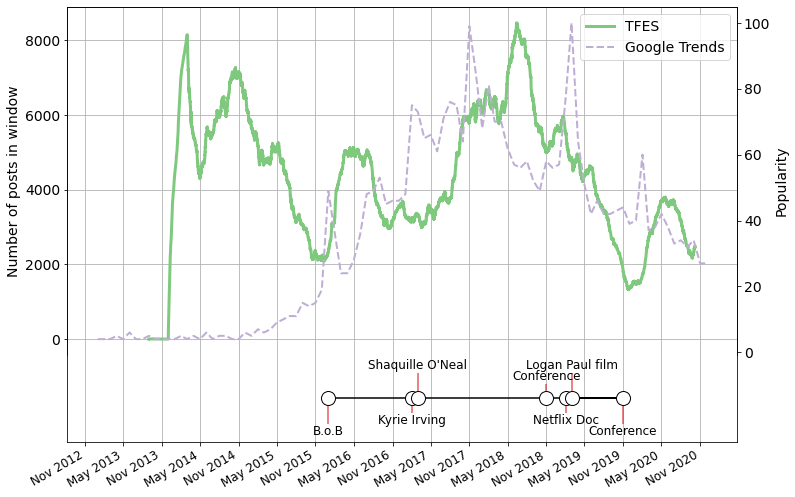

In [54]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

ax2 = ax.twinx()

ax.plot(all_posts["time"], rolling_post_counts.values, color=MAIN_COLOUR, lw=3)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()

ax2.plot(trends.index, trends.values, color=SECOND_COLOUR, linestyle="--", lw=2)
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("Popularity", fontsize=14)
plt.setp(ax2.get_xticklabels(), fontsize=0)
plt.setp(ax2.get_yticklabels(), fontsize=14)
ax2.spines['bottom'].set_visible(False)
# ax2.grid()

# for e in events.index:
#     ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
#     ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

# Comment this chunk out if you don't want the timeline
names = events.event
dates = events.index
plot_timeline(ax_time, dates, names, fontsize=12)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], linestyle="-", color=MAIN_COLOUR, lw=3),
                Line2D([0], [0], linestyle="--", color=SECOND_COLOUR, lw=2)]

ax2.legend(custom_lines, ['TFES', 'Google Trends'], fontsize=14)

fig.savefig(os.path.join(GRAPH_DIR, "google_trends.pdf"))
plt.show()

## Posts by section

In [55]:
flat_earth_posts.loc[:,"flag"] = [True] * len(flat_earth_posts)
off_topic_posts.loc[:,"flag"] = [True] * len(off_topic_posts)

c:\users\eddie\documents\thesis code\thesis_flat_earth\env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\eddie\documents\thesis code\thesis_flat_earth\env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


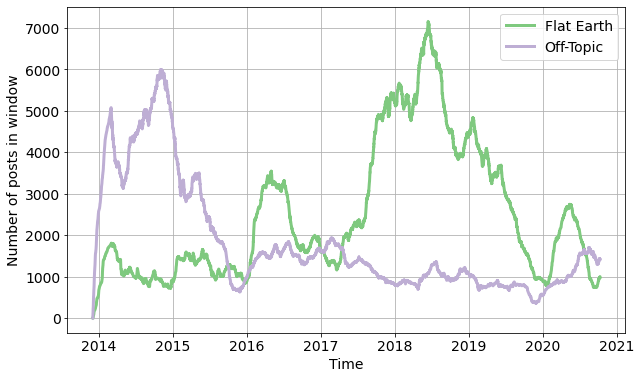

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(flat_earth_posts["time"], 
        flat_earth_posts.rolling("90D", on="time").count()["flag"].values, 
        color=MAIN_COLOUR, lw=3, label="Flat Earth")
ax.plot(off_topic_posts["time"], 
        off_topic_posts.rolling("90D", on="time").count()["flag"].values, 
        color=SECOND_COLOUR, lw=3, label="Off-Topic")
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
ax.legend(fontsize=14)
fig.savefig(os.path.join(GRAPH_DIR, "posts_over_time_by_section.pdf"))
plt.show()

## First Posts Over Time

In [57]:
first_posts = pd.DataFrame(all_posts["time"].groupby(all_posts["poster_id"]).min())
first_posts.loc[:,"flag"] = [True] * len(first_posts)
first_posts = first_posts.sort_values("time", ascending=True)
rolling_first_posts = first_posts.rolling("90D", on="time").count()["flag"]

In [58]:
rolling_first_posts

poster_id
1.0        1.0
5.0        2.0
6.0        3.0
11.0       1.0
12.0       2.0
          ... 
2314.0    54.0
2315.0    55.0
2316.0    56.0
2317.0    57.0
2318.0    58.0
Name: flag, Length: 2318, dtype: float64

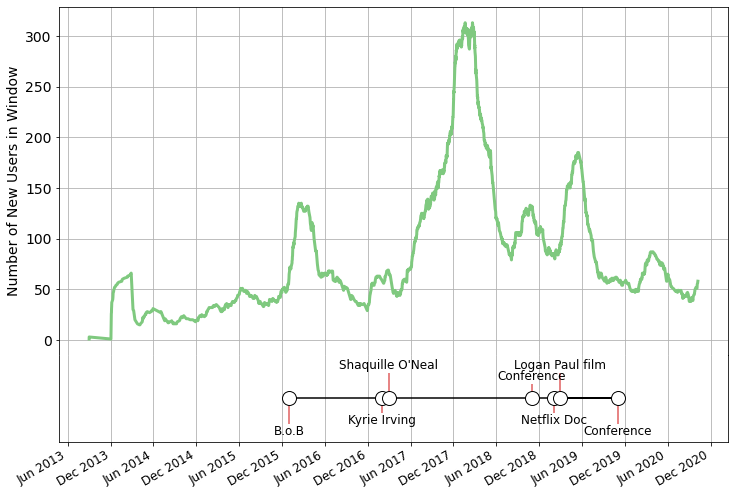

In [59]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

ax.plot(first_posts["time"], rolling_first_posts.values, color=MAIN_COLOUR, lw=3)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of New Users in Window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()

# for e in events.index:
#     ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
#     ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

# Comment this chunk out if you don't want the timeline
names = events.event
dates = events.index
plot_timeline(ax_time, dates, names, fontsize=12)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

fig.savefig(os.path.join(GRAPH_DIR, "new_users_over_time.pdf"))
plt.show()

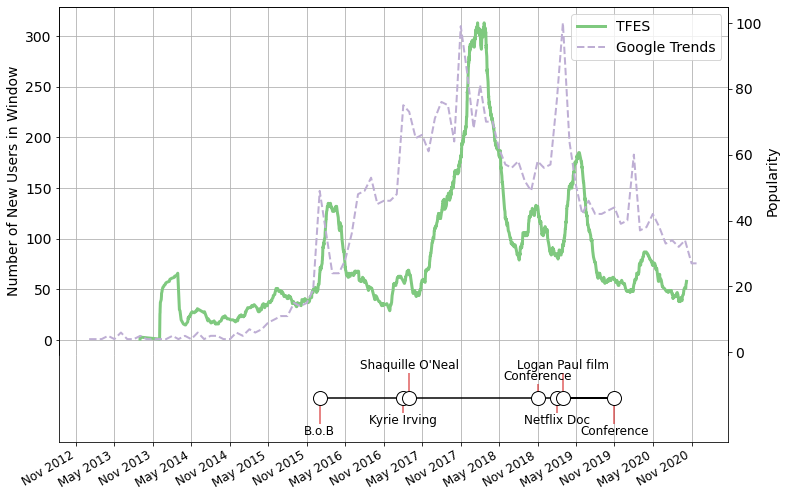

In [60]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

ax2 = ax.twinx()

ax.plot(first_posts["time"], rolling_first_posts.values, color=MAIN_COLOUR, lw=3)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of New Users in Window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()

ax2.plot(trends.index, trends.values, color=SECOND_COLOUR, linestyle="--", lw=2)
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("Popularity", fontsize=14)
plt.setp(ax2.get_xticklabels(), fontsize=0)
plt.setp(ax2.get_yticklabels(), fontsize=14)
ax2.spines['bottom'].set_visible(False)
# ax2.grid()

# for e in events.index:
#     ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
#     ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

# Comment this chunk out if you don't want the timeline
names = events.event
dates = events.index
plot_timeline(ax_time, dates, names, fontsize=12)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], linestyle="-", color=MAIN_COLOUR, lw=3),
                Line2D([0], [0], linestyle="--", color=SECOND_COLOUR, lw=2)]

ax2.legend(custom_lines, ['TFES', 'Google Trends'], fontsize=14)

# fig.savefig(os.path.join(GRAPH_DIR, "google_trends.pdf"))
plt.show()

## Posts over time (low posters)

In [61]:
under_10 = all_posts[all_posts["poster_id"].isin(posts_per_user[posts_per_user < 10].index)]
rolling_under_10 = under_10.rolling("90D", on="time").count()["flag"]

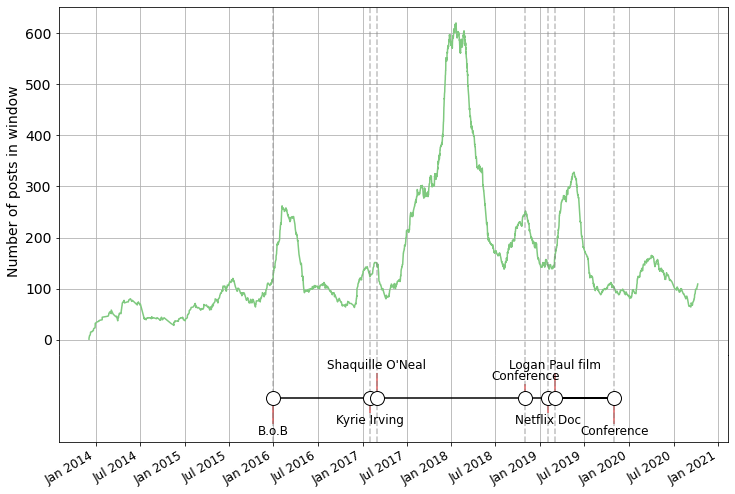

In [62]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

ax.plot(under_10["time"], rolling_under_10.values, color=MAIN_COLOUR)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()

for e in events.index:
    ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
    ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

# Comment this chunk out if you don't want the timeline
names = events.event
dates = events.index
plot_timeline(ax_time, dates, names, fontsize=12)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

# fig.savefig(os.path.join(GRAPH_DIR, "window_posts_over_time.pdf"))
plt.show()

## Posts over time (single day)

In [63]:
one_day = all_posts[all_posts["poster_id"].isin(user_lifetimes[user_lifetimes == 1].index)]
rolling_one_day = one_day.rolling("90D", on="time").count()["flag"]

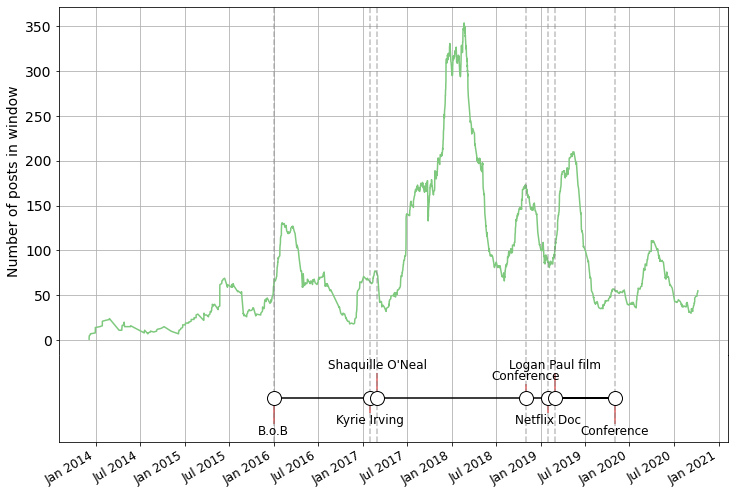

In [64]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

ax.plot(one_day["time"], rolling_one_day.values, color=MAIN_COLOUR)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()

for e in events.index:
    ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
    ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

# Comment this chunk out if you don't want the timeline
names = events.event
dates = events.index
plot_timeline(ax_time, dates, names, fontsize=12)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

# fig.savefig(os.path.join(GRAPH_DIR, "window_posts_over_time.pdf"))
plt.show()

## Distribution of Posts Across the Day

In [65]:
times = all_posts["time"].apply(lambda x: x.time())
hours = times.apply(lambda x: x.hour)
hour_counts = hours.groupby(hours).size()

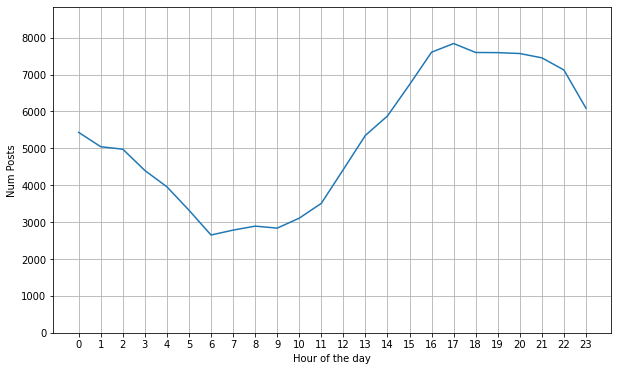

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(hour_counts)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Num Posts")
ax.set_ylim([0, hour_counts.max()+1000])
ax.set_xticks(hour_counts.index)
ax.grid()
plt.show()

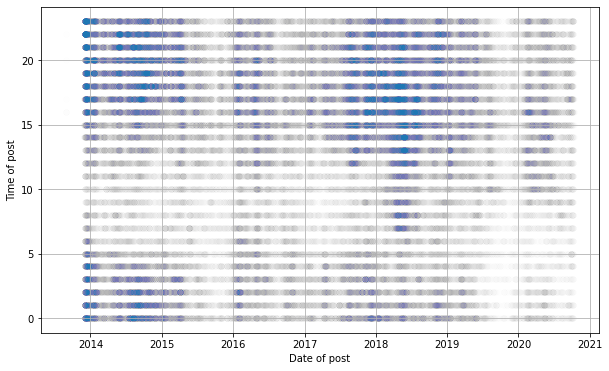

In [67]:
pd.plotting.register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(all_posts["time"], hours, alpha=0.005)
ax.set_xlabel("Date of post")
ax.set_ylabel("Time of post")
ax.grid()
plt.show()